# Proyek Klasifikasi Gambar: Facemask Detection
- **Nama:** Fattah Al Mahdi
- **Email:** ftthalmhdi@gmail.com
- **ID Dicoding:** nei.hash

## Import Semua Packages/Library yang Digunakan

In [12]:
# common lib
import os , shutil
import zipfile
import random
import pathlib
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from random import sample
from shutil import copyfile
from pathlib import Path
from tqdm.notebook import tqdm as tq
warnings.simplefilter(action='ignore', category=FutureWarning)
from google.colab import files

# image lib
import cv2
import skimage
from PIL import Image
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# model creation
import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model


In [14]:
pip freeze > requirements.txt

## Data Preparation

### Data Loading

In [2]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ftthalmhdi","key":"dcc055c6669c33c95c9b51d3b4c95add"}'}

In [3]:
!kaggle datasets download ashishjangra27/face-mask-12k-images-dataset
!unzip face-mask-12k-images-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Face Mask Dataset/Train/WithoutMask/1855.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1856.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1857.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1858.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1859.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1860.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1861.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1862.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1863.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1864.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1865.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1866.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1867.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1868.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1869.png  
  inflating: Face Mask Dataset/Train/WithoutMask/

In [7]:
train_dir = './Face Mask Dataset/Train'
test_dir = './Face Mask Dataset/Test'
valid_dir = './Face Mask Dataset/Validation'

combined_dir = './Face Mask Dataset/Combined'

In [8]:
os.makedirs(combined_dir,exist_ok=True)

In [9]:
for x in os.listdir(train_dir):
  x_dir = os.path.join(train_dir,x)
  if os.path.isdir(x_dir):
    shutil.copytree(x_dir,os.path.join(combined_dir,x),dirs_exist_ok=True)

for x in os.listdir(test_dir):
  x_dir = os.path.join(test_dir,x)
  if os.path.isdir(x_dir):
    shutil.copytree(x_dir,os.path.join(combined_dir,x),dirs_exist_ok=True)

for x in os.listdir(valid_dir):
  x_dir = os.path.join(valid_dir,x)
  if os.path.isdir(x_dir):
    shutil.copytree(x_dir,os.path.join(combined_dir,x),dirs_exist_ok=True)



In [11]:
# beri label pada masing masing file gambar
path = "Face Mask Dataset/Combined"
for class_name in os.listdir(path):
    class_path = os.path.join(path, class_name)
    if os.path.isdir(class_path):
        print(f"Memproses folder: {class_name}")

        for filename in os.listdir(class_path):
            if filename.endswith(('.jpg', '.png', '.tiff')):  # Filter file gambar

                old_path = os.path.join(class_path, filename)

                new_filename = f"{class_name}_{filename}"  # Misal: WithoutMask_1010101.jpg
                new_path = os.path.join(class_path, new_filename)

                # Rename file
                try:
                    os.rename(old_path, new_path)
                    print(f"Renamed: {filename} -> {new_filename}")
                except Exception as e:
                    print(f"Gagal rename {filename}: {e}")

print("Proses rename selesai!")

Streaming output truncated to the last 5000 lines.
Renamed: Augmented_732_8802821.png -> WithMask_Augmented_732_8802821.png
Renamed: Augmented_441_1658035.png -> WithMask_Augmented_441_1658035.png
Renamed: Augmented_266_4133371.png -> WithMask_Augmented_266_4133371.png
Renamed: Augmented_448_6755873.png -> WithMask_Augmented_448_6755873.png
Renamed: Augmented_304_8575095.png -> WithMask_Augmented_304_8575095.png
Renamed: Augmented_249_3712910.png -> WithMask_Augmented_249_3712910.png
Renamed: Augmented_208_5548554.png -> WithMask_Augmented_208_5548554.png
Renamed: Augmented_492_558837.png -> WithMask_Augmented_492_558837.png
Renamed: 1167.png -> WithMask_1167.png
Renamed: Augmented_27_3059542.png -> WithMask_Augmented_27_3059542.png
Renamed: Augmented_786_4891175.png -> WithMask_Augmented_786_4891175.png
Renamed: Augmented_234_3710611.png -> WithMask_Augmented_234_3710611.png
Renamed: Augmented_409_5867557.png -> WithMask_Augmented_409_5867557.png
Renamed: Augmented_530_8896737.png -> 

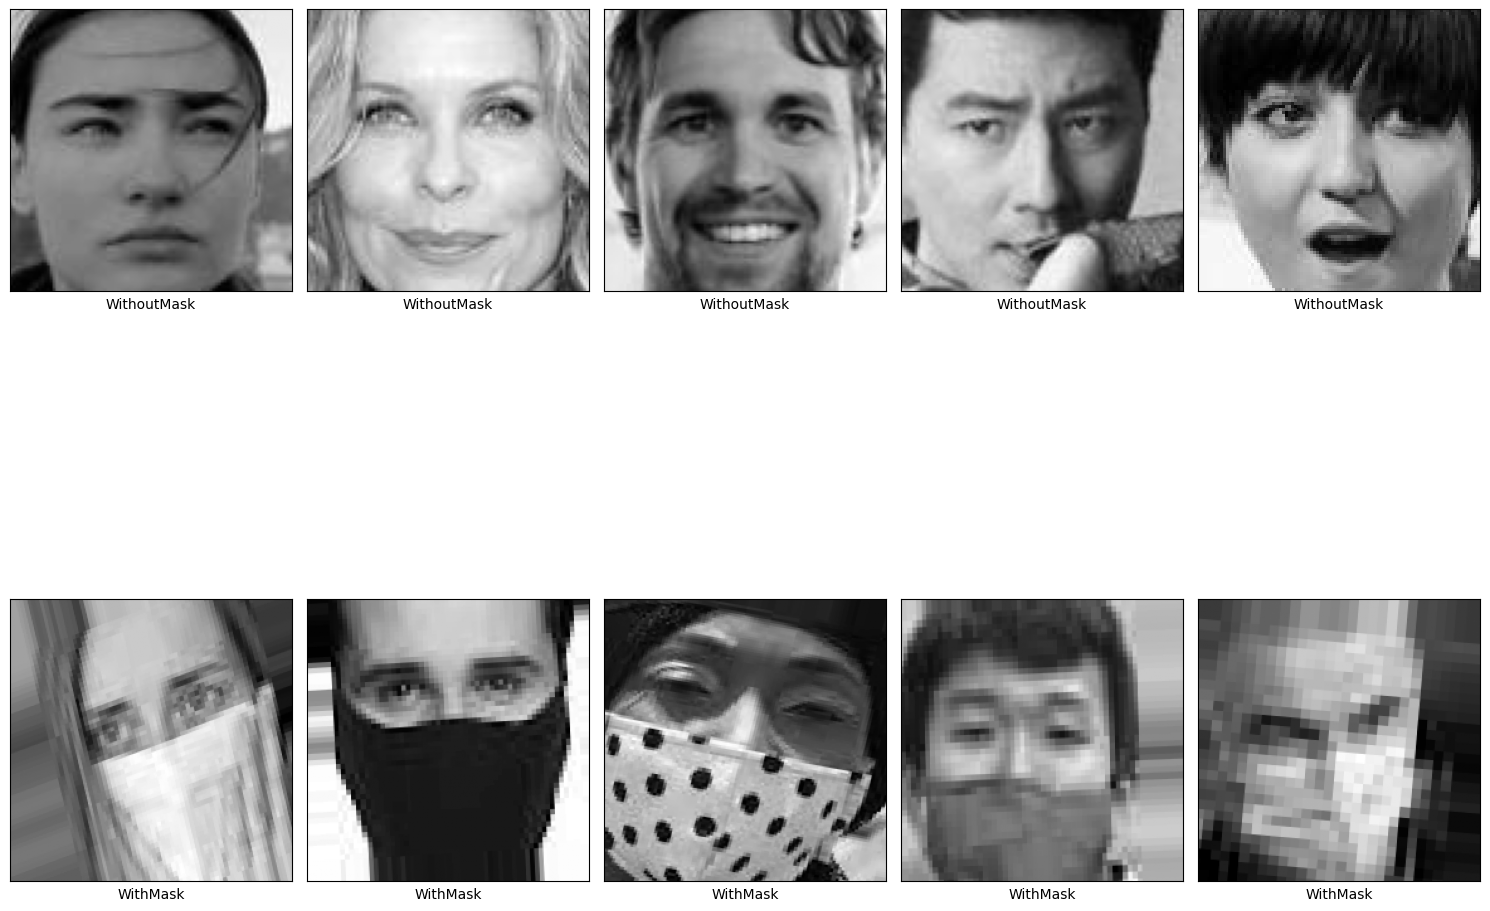

In [12]:
face_images = {}

path = "Face Mask Dataset"
path_sub = os.path.join(path,"Combined")
for i in os.listdir(path_sub):
  face_images[i] = os.listdir(os.path.join(path_sub,i))

path_sub = "Face Mask Dataset/Combined"
fig, axs = plt.subplots(len(face_images.keys()), 5, figsize=(15, 15))

for i , class_name in enumerate(os.listdir(path_sub)):
  images = np.random.choice(face_images[class_name],5,replace=False)

  for j , image_names in enumerate(images):
    img_path = os.path.join(path_sub,class_name,image_names)
    img = Image.open(img_path).convert('L')
    axs[i, j].imshow(img, cmap='gray')
    axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])
fig.tight_layout()


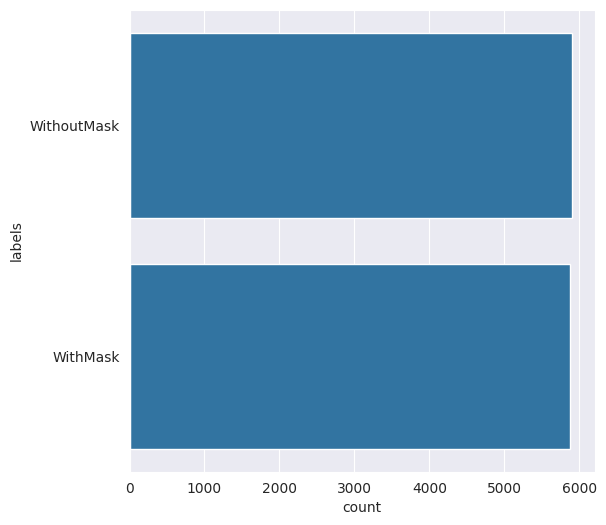

In [14]:
face_images_path = "Face Mask Dataset/Combined/"
file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(face_images_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

### Data Preprocessing

#### Split Dataset

In [22]:
mypath = 'Face Mask Dataset/Combined'

file_names = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_names.append(name)

print(len(full_path), len(labels), len(file_name))
df = pd.DataFrame({"path":full_path, 'file_name':file_names, "labels":labels})
df.groupby(['labels']).size()

11792 11792 58960


,0
labels,
WithMask,5883
WithoutMask,5909


In [23]:
X= df['path']
y= df['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=300)

In [24]:
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

In [25]:
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sampel data
print(df_all.sample(5))

# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "chest_xray/dataset/"
# Membuat variabel Dataset, tempat menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "Dataset-Final/"


set    labels     
test   WithMask       1189
       WithoutMask    1170
train  WithMask       4694
       WithoutMask    4739
dtype: int64 


                                                   path       labels    set
5505  Face Mask Dataset/Combined/WithoutMask/Without...  WithoutMask  train
8920  Face Mask Dataset/Combined/WithMask/WithMask_A...     WithMask  train
6410  Face Mask Dataset/Combined/WithoutMask/Without...  WithoutMask  train
7051  Face Mask Dataset/Combined/WithoutMask/Without...  WithoutMask  train
7502  Face Mask Dataset/Combined/WithoutMask/Without...  WithoutMask  train


In [26]:
    for index, row in tq(df_all.iterrows()):
        # Deteksi filepath
        file_path = row['path']
        if os.path.exists(file_path) == False:
                file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

        # Buat direktori tujuan folder
        if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
            os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

        # Tentukan tujuan file
        destination_file_name = file_path.split('/')[-1]
        file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

        # Salin file dari sumber ke tujuan
        if os.path.exists(file_dest) == False:
            shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

In [29]:
TRAIN_DIR = "Dataset-Final/train"
TEST_DIR = "Dataset-Final/test"

train_mask = os.path.join(TRAIN_DIR + '/WithMask')
train_outmask = os.path.join(TRAIN_DIR + '/WithoutMask')
test_mask = os.path.join(TEST_DIR + '/WithMask')
test_outmask = os.path.join(TEST_DIR + '/WithoutMask')

print("Total number of WithMask images in training set: ",len(os.listdir(train_mask)))
print("Total number of WithoutMask images in training set: ",len(os.listdir(train_outmask)))
print("Total number of WithMask images in test set: ",len(os.listdir(test_mask)))
print("Total number of WithoutMask images in test set: ",len(os.listdir(test_outmask)))

Total number of WithMask images in training set:  4694
Total number of WithoutMask images in training set:  4739
Total number of WithMask images in test set:  1189
Total number of WithoutMask images in test set:  1170


In [30]:
datagen = ImageDataGenerator(rescale=1/255.,
                             validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(150,150),
                                              color_mode="grayscale",
                                              class_mode='binary',
                                              subset='training',
                                              shuffle=True)

validation_generator = datagen.flow_from_directory(TRAIN_DIR,
                                                   batch_size=32,
                                                   target_size=(150,150),
                                                color_mode="grayscale",
                                                   class_mode='binary',
                                                   subset='validation',
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=1,
                                                  target_size=(150,150),
                                                  color_mode="grayscale",
                                                  class_mode='binary',
                                                  shuffle=False)

Found 7548 images belonging to 2 classes.
Found 1885 images belonging to 2 classes.
Found 2359 images belonging to 2 classes.


## Modelling

In [31]:
tf.keras.backend.clear_session()

In [32]:
model = Sequential([
    # Layer 1
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150, 150, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Layer 2
    Conv2D(32, (4, 4), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Layer 3
    Conv2D(32, (7, 7), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Layer Fully Connected
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

print(model.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 32)          │          16,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 75, 75, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 37, 37, 32)          │          50,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 37, 37, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,327,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,394,689 (5.32 MB)

 Trainable params: 1,394,497 (5.32 MB)

 Non-trainable params: 192 (768.00 B)

None


In [33]:
test_1 = model.fit(train_generator,
                    epochs=30,
                    batch_size=32,
                    validation_data=validation_generator
)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


236/236 ━━━━━━━━━━━━━━━━━━━━ 29s 91ms/step - accuracy: 0.9016 - loss: 0.3601 - val_accuracy: 0.6637 - val_loss: 0.8184
Epoch 2/30
236/236 ━━━━━━━━━━━━━━━━━━━━ 17s 74ms/step - accuracy: 0.9797 - loss: 0.0753 - val_accuracy: 0.6382 - val_loss: 1.7969
Epoch 3/30
236/236 ━━━━━━━━━━━━━━━━━━━━ 16s 66ms/step - accuracy: 0.9890 - loss: 0.0323 - val_accuracy: 0.8881 - val_loss: 0.4766
Epoch 4/30
236/236 ━━━━━━━━━━━━━━━━━━━━ 17s 72ms/step - accuracy: 0.9878 - loss: 0.0402 - val_accuracy: 0.8058 - val_loss: 0.7688
Epoch 5/30
236/236 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.9890 - loss: 0.0429 - val_accuracy: 0.9178 - val_loss: 0.9744
Epoch 6/30
236/236 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.9964 - loss: 0.0084 - val_accuracy: 0.9220 - val_loss: 1.0218
Epoch 7/30
236/236 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.9970 - loss: 0.0143 - val_accuracy: 0.7666 - val_loss: 2.3123
Epoch 8/30
236/236 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.9970 - loss: 0.0093 - val_accurac

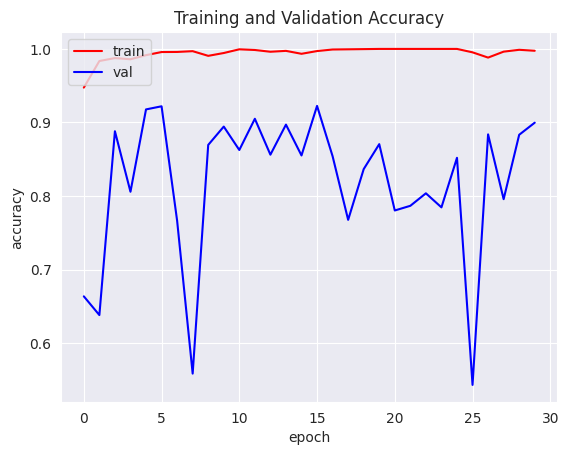

Text(0.5, 1.0, 'Training and Validaion Loss')

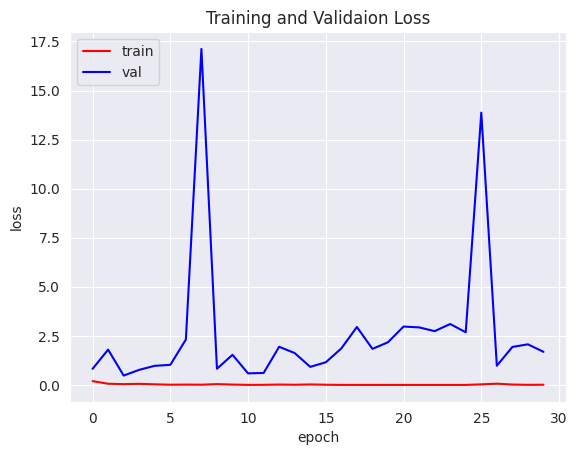

In [34]:
acc = test_1.history['accuracy']
val_acc = test_1.history['val_accuracy']
loss = test_1.history['loss']
val_loss = test_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')

## Evaluasi dan Visualisasi



              precision    recall  f1-score   support

    WithMask     0.9770    0.9630    0.9699      1189
 WithoutMask     0.9629    0.9769    0.9699      1170

    accuracy                         0.9699      2359
   macro avg     0.9699    0.9700    0.9699      2359
weighted avg     0.9700    0.9699    0.9699      2359



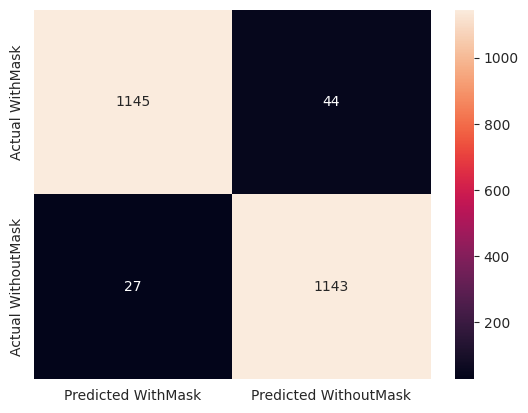

In [37]:
    test_generator.reset()

    preds_1 = model.predict(test_generator,verbose=0)
    preds_1 = preds_1.copy()
    preds_1[preds_1 <= 0.5] = 0
    preds_1[preds_1 > 0.5] = 1

    # Print Confusion Matrix
    cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, preds_1, labels=[0, 1]),index=["Actual WithMask", "Actual WithoutMask"],
    columns=["Predicted WithMask", "Predicted WithoutMask"])
    sns.heatmap(cm,annot=True,fmt="d")

    # Print Classification Report
    print("\n")
    print(classification_report(y_true=test_generator.classes,y_pred=preds_1,target_names =['WithMask','WithoutMask'], digits=4))

# Summary
model dapat membedakan wajah seseorang yang menggunakan masker dan yang tidak menggunakan masker dengan baik hal ini dapat dilihat dari confussion matrix yang menunjukan tingkat accuracy 96%

## Konversi Model

## Saved Model

In [43]:
path_model = 'default_tf/'
tf.saved_model.save(model,path_model)

## TFJS

In [1]:
!pip install tensorflowjs

In [4]:
    !tensorflowjs_converter \
        --input_format 'tf_saved_model' \
        /content/default_tf/ \
        /content/modeltfjs

2025-03-16 04:02:41.793307: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742097761.814360   32057 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742097761.820634   32057 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742097761.836860   32057 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742097761.836893   32057 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742097761.836897   32057 computation_placer.cc:177] computation placer alr

## Tflite

In [10]:
    converter = tf.lite.TFLiteConverter.from_saved_model("default_tf")
    tflite_model = converter.convert()

    with tf.io.gfile.GFile('model.tflite', 'wb') as f:
        f.write(tflite_model)

## Inference (Optional)